### Latent ideology of users

LI is based on the media outlet shared by each user, therefore the ideology reflects the group of media an user shares.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import matplotlib 

np.random.seed(123459)

In [2]:
# Data with only columns of interest
data = pd.read_csv('Data/dataEchoChambers_with_article_info.csv', usecols=['tw_id', 'fecha', 'usr_id', 'opinion_dinamic', 'url_expanded', 'medio'])
data['fecha'] = pd.to_datetime(data['fecha'])
data.head(n = 5)

,fecha,url_expanded,medio,opinion_dinamic,tw_id,usr_id
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346910135377920,716295311342321665
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346845589233665,271519704
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350580142903296,987494618156675072
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350441126936580,770375532
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101353444135370754,740350122974937088


### Encoding matrix user - media share
User - media shares dataframe based on one-hot encoding of media shares

In [3]:
user_media_df = pd.DataFrame()

# user_id column
user_media_df['usr_id'] = data['usr_id']

#creating instance of one-hot-encoder and one-hot encoding of media shares
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data[['medio']]).toarray())
encoder_df.columns = list(encoder.categories_[0])

user_media_df = user_media_df.join(encoder_df)

In [4]:
user_media_df = user_media_df.groupby('usr_id').sum()
user_media_df.head(n = 5)

,Ambito Financiero,Clarin,Contexto,Diario Registrado,El Cronista,El Destape,El Dia,El Litoral,Infobae,Jornada,La Izquierda Diario,La Nacion,Minuto Uno,Pagina 12,Perfil,Radio Dos,Radio Mitre,TYC Sports,Todo Noticias
usr_id,,,,,,,,,,,,,,,,,,,
12864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59173,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
624143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
760916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ppal_media = ['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae', 'El Destape']
ppal_media += ['Ambito Financiero', 'Minuto Uno', 'Perfil', 'El Cronista', 'Radio Mitre', 'El Dia']

user_media_df_filtrado = user_media_df[ppal_media].copy()
user_media_df_filtrado = user_media_df_filtrado[user_media_df_filtrado.apply(np.count_nonzero, axis = 1) > 0].copy()

In [6]:
# Matrix of user - media shared
A = user_media_df_filtrado.to_numpy()

In [7]:
score_users = np.random.normal(loc = 0, scale = 1.00, size = A.shape[0])
score_users = (score_users - np.mean(score_users))/np.std(score_users)

for iteration in range(50):
    
    score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
    score_users = np.array([np.average(score_media, weights=A[j,:]) for j in range(A.shape[0])])

    score_users = (score_users - np.mean(score_users))/np.std(score_users)

In [8]:
score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
media_score = [[user_media_df_filtrado.columns[i], score_media[i]] for i in range(len(score_media))]
print(media_score)

[['Clarin', 0.609661999211148], ['La Nacion', 0.5312879166183917], ['Pagina 12', -1.3626397807373856], ['Todo Noticias', 0.6419815284240711], ['Infobae', 0.39850498120660227], ['El Destape', -1.4959403799483069], ['Ambito Financiero', -0.5587326463353376], ['Minuto Uno', -1.291277582825876], ['Perfil', -0.05070000145797923], ['El Cronista', 0.11570807397797654], ['Radio Mitre', 1.3257852341732044], ['El Dia', 0.30968440723347196]]


[-1.75602129  0.8704686 ]


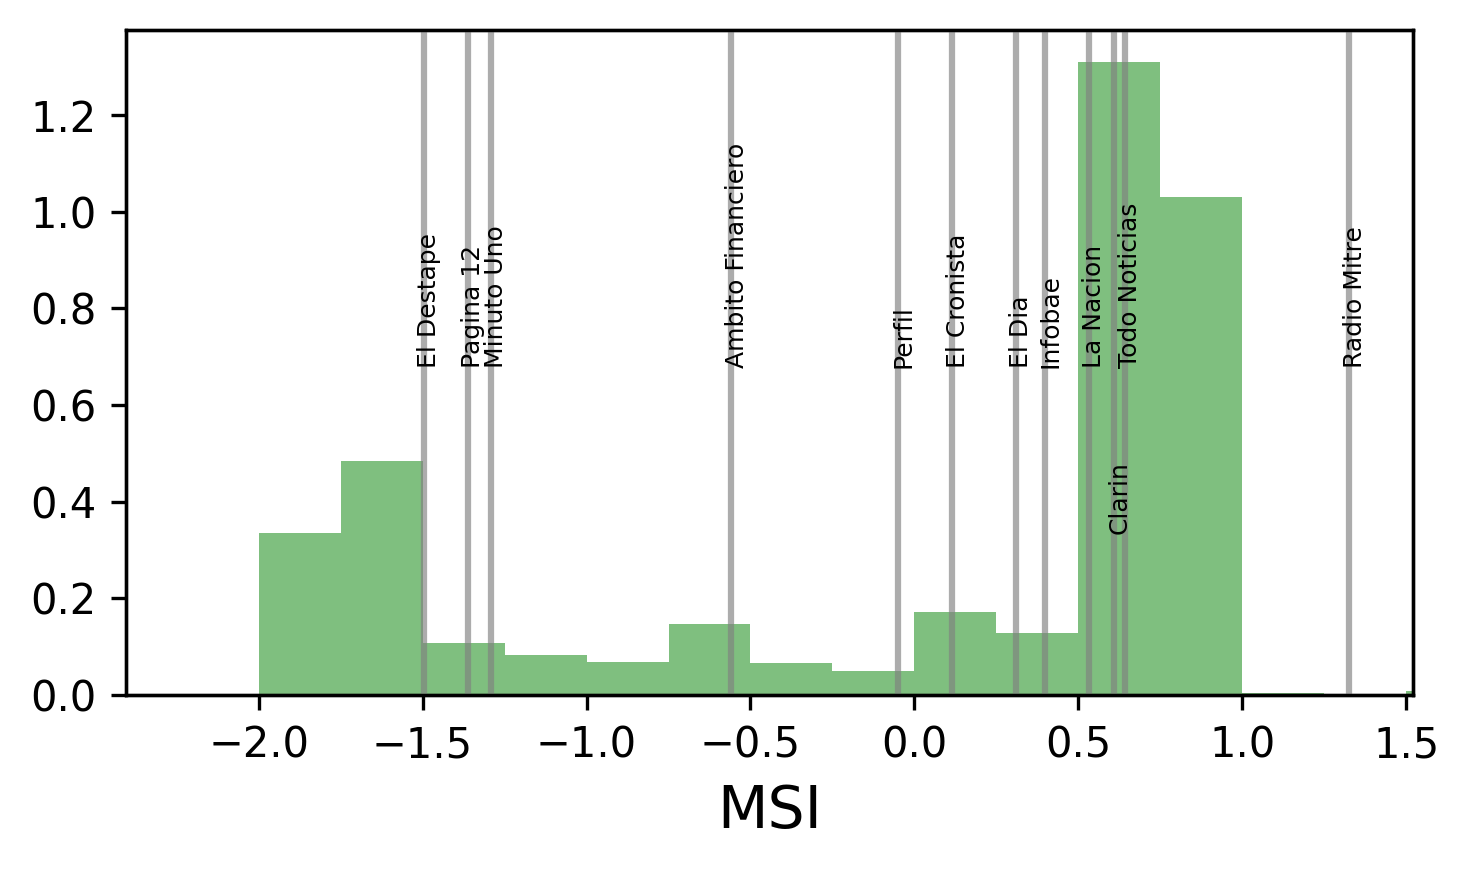

In [9]:
# Scores of the users
fig, ax = plt.subplots(dpi = 300, figsize=(5,3))

ax.hist(score_users, bins = np.arange(-2, 2, 0.25), alpha = 0.50, color = 'g', density = True)
ax.set_xlabel(r'MSI', size = 14)

ax2 = ax.twinx()
for ms in media_score:
    ax2.axvline(ms[1], color = 'grey', alpha = 0.65)
    if ms[0] != 'Clarin':
        ax2.text(x = ms[1]-0.02, y = 0.5, s=ms[0], rotation = 90, size = 6)
    else: 
        ax2.text(x = ms[1]-0.02, y = 0.25, s=ms[0], rotation = 90, size = 6)
ax2.set_yticks([])
ax.set_xlim(np.quantile(score_users, q = [0.005, 0.995]) + np.array([-0.65, 0.65]))
print(np.quantile(score_users, q = [0.005, 0.995]))
fig.tight_layout()
plt.savefig('Results/MSI.pdf')#, bbox_inches = matplotlib.transforms.Bbox.from_bounds(0, -0.25, 5, 2.25))
plt.savefig('Results/MSI.png')#, bbox_inches = matplotlib.transforms.Bbox.from_bounds(0, -0.25, 5, 2.25))
plt.show()

In [10]:
print(np.quantile(score_users, q = [0.005, 0.995]))


[-1.75602129  0.8704686 ]


In [11]:
user_media_df_filtrado['score'] = score_users

In [12]:
user_media_df_filtrado['score'].to_csv('Results/MSI_users_score_with_1outletshared.csv')

### Relation with ideology

In [13]:
from scipy.stats import mode 

user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])

ideology_of_msi_users = user_ideology[user_ideology.index.isin(user_media_df_filtrado.index)].to_list()

user_media_df_filtrado['ideology'] = ideology_of_msi_users

/tmp/ipykernel_139039/3854437867.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])
/tmp/ipykernel_139039/3854437867.py:3: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])


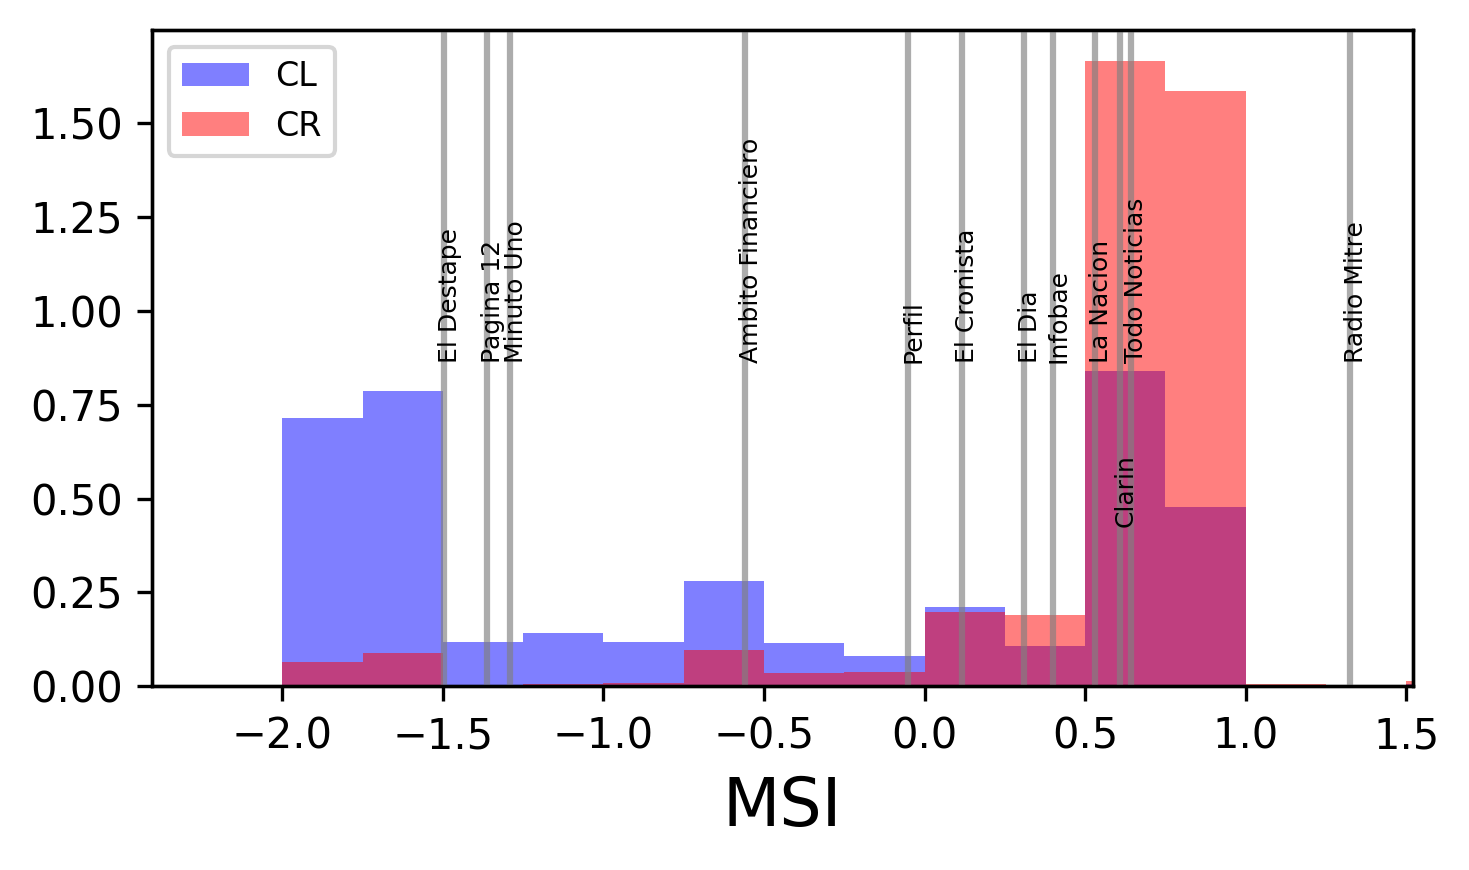

In [15]:
# Scores of the users
fig, ax = plt.subplots(dpi = 300, figsize=(5,3))


ideocolor = {'FF': 'b', 'MP': 'r'}
for ideology in ['FF', 'MP']:
    ax.hist(user_media_df_filtrado[user_media_df_filtrado['ideology'] == ideology]['score'], bins = np.arange(-2, 2, 0.25), alpha = 0.50, color = ideocolor[ideology], density = True, label = ['CL' if ideology == 'FF' else 'CR'])
ax.set_xlabel(r'MSI', size = 16)
ax.legend(loc = 'upper left', fontsize = 8)

ax2 = ax.twinx()
for ms in media_score:
    ax2.axvline(ms[1], color = 'grey', alpha = 0.65)
    if ms[0] != 'Clarin':
        ax2.text(x = ms[1]-0.02, y = 0.5, s=ms[0], rotation = 90, size = 6)
    else: 
        ax2.text(x = ms[1]-0.02, y = 0.25, s=ms[0], rotation = 90, size = 6)
ax2.set_yticks([])
ax.set_xlim(np.quantile(score_users, q = [0.005, 0.995]) + [-0.65, 0.65])
fig.tight_layout()
plt.savefig('Results/MSI_ideology.pdf')#, bbox_inches = matplotlib.transforms.Bbox.from_bounds(0, -0.25, 5, 2.25))
plt.savefig('Results/MSI_ideology.png')#, bbox_inches = matplotlib.transforms.Bbox.from_bounds(0, -0.25, 5, 2.25))
plt.show()

### Relation with sentiment bias 

In [14]:
media_score

In [15]:
df_aux = pd.read_csv('Data/dataEchoChambers_with_article_info.csv').drop_duplicates(subset=['url_expanded'])

In [16]:
def SB_Albanese2020(x):
    ans = (x['pos_mp'] - x['neg_mp']) - (x['pos_ff'] - x['neg_ff'])
    norm = x['N_ff'] + x['N_mp']
    if norm != 0:
        ans /= norm
        return ans 
    else:
        return np.nan

In [17]:
df_aux['SB'] = df_aux.apply(lambda x: SB_Albanese2020(x), axis = 1)

In [18]:
SB_medio = df_aux.groupby('medio')['SB'].mean().sort_values().reset_index()

In [19]:
SB_medio = SB_medio[SB_medio.medio.isin(ppal_media)].copy()

In [20]:
SB_medio.sort_values('medio', inplace=True)

In [21]:
msi = [m[1] for m in sorted(media_score, key = lambda x: x[0])]

In [22]:
SB_medio['MSI'] = msi

In [23]:
# Scores of the users
fig, ax = plt.subplots(dpi = 300, figsize=(7,7))

ax.scatter(SB_medio['MSI'], SB_medio['SB'], alpha = 0.50, color = 'g', s = 500)
ax.set_xlabel(r'MSI', size = 30)
ax.set_ylabel(r'$\langle SB \rangle$', size = 30)

for i in range(SB_medio.shape[0]):
    ax.text(SB_medio.iloc[i]['MSI'], SB_medio.iloc[i]['SB'], SB_medio.iloc[i]['medio'], size = 10)
    
ax.set_xlim([-2, 2])
ax.set_ylim(-0.20, 0.05)
#ax.set_title('Spearman r: {:.3f}'.format(SB_medio[['SB', 'MSI']].corr('spearman').to_numpy()[1,0]), size = 16)
ax.tick_params(axis='both', labelsize = 16)

fig.tight_layout()
plt.savefig('Results/MSI_SB.pdf')#, bbox_inches = matplotlib.transforms.Bbox.from_bounds(-0.5, -0.25, 7.25, 7.25))
plt.savefig('Results/MSI_SB.png')#, bbox_inches = matplotlib.transforms.Bbox.from_bounds(-0.5, -0.25, 7.25, 7.25))
plt.show()